In [1]:
import tensorflow as tf

from tensorflow.lite.experimental.microfrontend.python.ops import audio_microfrontend_op as frontend_op
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.python.platform import gfile

import tensorflow_model_optimization as tfmot

import functools

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os, pickle, sys, time
import shutil
import json
from scipy.io import  wavfile
from IPython import display

import str_ww_util as util
import get_dataset
import keras_model as models

from IPython import display

In [2]:
from get_dataset import get_data, get_file_lists, get_data_config

In [3]:
# jupyter will pass an extra -f=<tmp_file> arg, which throws an 
# unrecognized argument error
sys.argv = sys.argv[0:1] 

Flags = util.parse_command("train")

In [4]:
notebook_mode = "inference" # "inference" OR "short_training" OR "full_training"
tfl_file_name = "trained_models/str_ww_quant_model.tflite"
random_seed = 2024

if notebook_mode == "inference": 
  load_pretrained_model = True
  Flags.num_samples_training = 2000 # we don't need the full set for inference
  save_model = False
elif notebook_mode == "short_training":
  ## Set these for an extra short test just to validate that the code runs
  load_pretrained_model = False
  save_model = False
  Flags.num_samples_training = 2000
  Flags.num_samples_validation = 1000
  Flags.num_samples_test = 1000
  Flags.epochs = 10
elif notebook_mode == "full_training":
  ## Set these to for a full training run.
  load_pretrained_model = False # True to load from a file, False to build/train from scratch
  save_model = True
else:
  # Or make custom settings here
  pass

# 'trained_models/str_ww_model.h5' is the default save path for train.py
pretrained_model_path = 'trained_models/str_ww_ref_model.h5' # path to load from if load_pretrained_model is True

samp_freq = Flags.sample_rate

In [5]:
rng = np.random.default_rng(random_seed)

In [6]:
try:
    with open('streaming_config.json', 'r') as fpi:
        streaming_config = json.load(fpi)
    Flags.data_dir = streaming_config['speech_commands_path']
except:
    raise RuntimeError("""
        In this directory, copy streaming_config_template.json to streaming_config.json
        and edit it to point to the directories where you have the speech commands dataset
        and (optionally) the MUSAN noise data set.
        """)
Flags.bg_path = Flags.data_dir

In [7]:
ds_train, ds_test, ds_val = get_dataset.get_all_datasets(Flags)

About to get val data. 

2025-03-24 12:12:28.051044: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-03-24 12:12:28.051165: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 16.00 GB
2025-03-24 12:12:28.051171: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 5.33 GB
2025-03-24 12:12:28.051205: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-24 12:12:28.051688: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Building dataset with 2796 targets, 1398 silent, and 9786 other.
About to get train data. Building dataset with 400 targets, 200 silent, and 1400 other.
About to get test data. Building dataset with 3088 targets, 1544 silent, and 10810 other.
Done building datasets


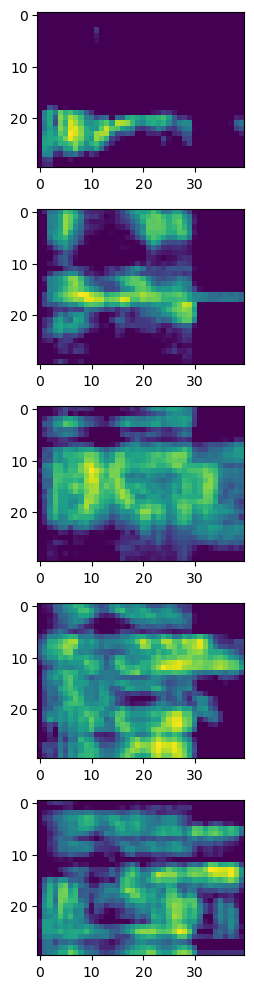

In [8]:
plt.figure(figsize=(10,10))
for i,(x,y) in enumerate(ds_train.unbatch()):
  if i < 5:
    plt.subplot(5,1,i+1)
    plt.imshow(np.squeeze(x))
  else:
    max_val = np.max(x)
plt.tight_layout()
    

In [9]:
for dat in ds_train.unbatch().take(1):
  print("One element from the training set has shape:")
  print(f"Input tensor shape: {dat[0].shape}")
  print(f"Label shape: {dat[1].shape}")
  print(f"Label : {dat[1]}")
  break


One element from the training set has shape:
Input tensor shape: (30, 1, 40)
Label shape: (3,)
Label : [0. 0. 1.]


These next two cells can be quite slow in the current implementation, so uncomment if you want to see them.
They
1. Show spectra of some target words
2. Count the distribution of classes in the training set

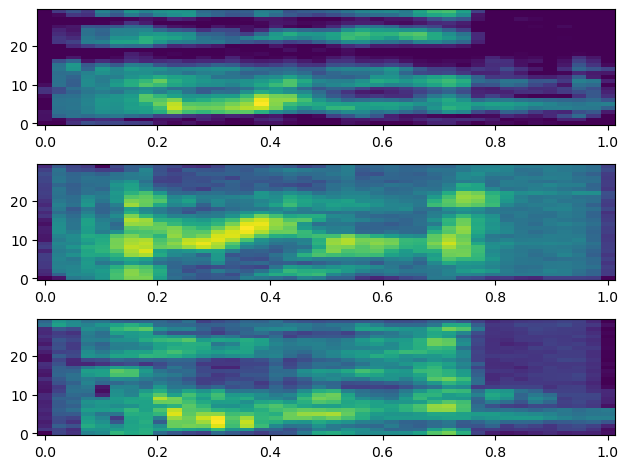

In [10]:
max_target_examples = 3
target_count = 0

plt.Figure(figsize=(10,4))
for dat in ds_train.unbatch():
  if np.argmax(dat[1]) == 0:
    target_count += 1
    ax = plt.subplot(max_target_examples, 1, target_count)
    # display.display(display.Audio(dat[0].numpy(), rate=16000))

    log_spec = dat[0].numpy().squeeze()
    height = log_spec.shape[0]
    width = log_spec.shape[1]
    X = np.linspace(0, 1.0, num=width, dtype=float)
    Y = range(height)
    ax.pcolormesh(X, Y, np.squeeze(log_spec))
    if target_count >= max_target_examples:
      break
plt.tight_layout()

In [11]:
## look at the label breakdown in the training set
print(get_dataset.count_labels(ds_train))



{2: 1400, 0: 400, 1: 200}


## Build and Train Model

In [12]:
if load_pretrained_model:
  print(f"Loading pretrained model from {pretrained_model_path}")
  with tfmot.quantization.keras.quantize_scope(): # needed for the QAT wrappers
    model = keras.models.load_model(pretrained_model_path)
else:
  print(f"Building model from scratch")
  model = models.get_model(args=Flags, use_qat=Flags.use_qat) # compile step is done inside get_model()

Loading pretrained model from trained_models/str_ww_ref_model.h5


In [13]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 30, 1, 40)]       0         
                                                                 
 depthwise_conv2d (Depthwis  (None, 28, 1, 40)         120       
 eConv2D)                                                        
                                                                 
 conv2d (Conv2D)             (None, 28, 1, 128)        5120      
                                                                 
 batch_normalization (Batch  (None, 28, 1, 128)        512       
 Normalization)                                                  
                                                                 
 activation (Activation)     (None, 28, 1, 128)        0         
                                                                 
 dropout (Dropout)           (None, 28, 1, 128)        0     

In [14]:
if not load_pretrained_model:
  callbacks = util.get_callbacks(args=Flags)
  train_hist = model.fit(ds_train, validation_data=ds_val, callbacks=callbacks,
                         epochs=Flags.epochs)

In [15]:
if save_model:
  model.save('trained_models/str_ww_model_nb.h5')

In [16]:
if not load_pretrained_model:
  plt.subplot(2,1,1)
  plt.semilogy(train_hist.epoch, train_hist.history['loss'], train_hist.history['val_loss'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.subplot(2,1,2)
  plt.plot(train_hist.epoch, train_hist.history['categorical_accuracy'], train_hist.history['val_categorical_accuracy'])
  plt.legend(['training', 'validation'])
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')


In [17]:
## This cell can be slow with QAT enabled
print(f"Eval on training set")
model.evaluate(ds_train)
print(f"Eval on validation set")
model.evaluate(ds_val)

Eval on training set


2025-03-24 12:12:38.073048: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.


20/20 [==============================] - 1s 20ms/step - loss: 0.0472 - categorical_accuracy: 0.9900 - precision: 0.9973 - recall: 0.9075
Eval on validation set
140/140 [==============================] - 40s 284ms/step - loss: 0.2531 - categorical_accuracy: 0.9552 - precision: 0.9955 - recall: 0.7139   


[0.2530636787414551,
 0.9551501870155334,
 0.9955112338066101,
 0.7138769626617432]

In [18]:
def build_and_plot_confusion_matrix(model, dataset, label_list=['marvin', 'silent', 'other']):
  dataset = dataset.cache() # prevent shuffling between where we get predictions and where we get labels
  model_out = model.predict(dataset)
  model_out = np.squeeze(model_out)
  y_pred_val = np.argmax(model_out, axis=1)
  
  y_true_val = np.nan*np.zeros(y_pred_val.shape[0])
  for i,dat in enumerate(dataset.unbatch()):
    y_true_val[i] = np.argmax(dat[1])
  
  acc = sum(y_pred_val == y_true_val) / len(y_true_val)
  print(f'Accuracy: {acc:.1%}')

  confusion_mtx = tf.math.confusion_matrix(y_true_val, y_pred_val) 
  plt.figure(figsize=(6, 6))
  sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
              annot=True, fmt='g')
  plt.gca().invert_yaxis() # flip so origin is at bottom left
  plt.xlabel('Prediction')
  plt.ylabel('Label')
  plt.show()

20/20 [==============================] - 0s 3ms/step
Accuracy: 99.0%


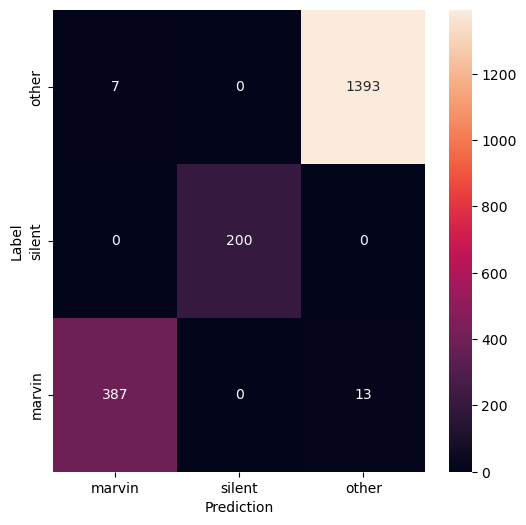

In [19]:
build_and_plot_confusion_matrix(model, ds_train)

## Post-Training Quantization

In [20]:
!python quantize.py --saved_model_path=trained_models/str_ww_ref_model.h5 \
                    --tfl_file_name=$tfl_file_name


/Users/jeremy/miniforge3/envs/jh_main/lib/python3.11/site-packages/tensorflow/lite/python/convert.py:947: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn(
fully_quantize: 0, inference_type: 6, input_inference_type: INT8, output_inference_type: INT8
Wrote to trained_models/str_ww_quant_model.tflite


#### Test Quantized Interpreter on One Spectrogram

In [21]:
interpreter = tf.lite.Interpreter(model_path=tfl_file_name)
interpreter.allocate_tensors()
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
input_shape = input_details[0]['shape']
output_data = []
labels = []
input_scale, input_zero_point = input_details[0]["quantization"]
output_scale, output_zero_point = output_details[0]["quantization"]

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [22]:
spec, label = next(ds_val.unbatch().batch(1).take(1).as_numpy_iterator())

spec_q = np.array(spec/input_scale + input_zero_point, dtype=np.int8)

interpreter.set_tensor(input_details[0]['index'], spec_q)
interpreter.invoke()
out_vec = interpreter.get_tensor(output_details[0]['index'])
pred_label = np.argmax(out_vec)
out_vec_dequant = (out_vec.astype(np.float32) - output_zero_point)*output_scale

print(f"Output = {out_vec}.")
print(f"True (vs predicted) label = {np.argmax(label)} (vs {pred_label})")
print(f"Dequantized output vector = {out_vec_dequant}")

Output = [[-128 -128  127]].
True (vs predicted) label = 2 (vs 2)
Dequantized output vector = [[0.         0.         0.99609375]]


#### Now Measure Quantized Accuracy on Validation Set

In [23]:
t0 = time.time(); 
predictions = []
labels = []
# num_test_samples = 100

eval_ds = ds_val # ds_val OR ds_train OR ds_test

for next_spec, next_label in eval_ds.unbatch().batch(1): # .take(num_test_samples):    
  spec_q = np.array(next_spec/input_scale + input_zero_point, dtype=np.int8)
  interpreter.set_tensor(input_details[0]['index'], spec_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  predictions.append(np.argmax(interpreter.get_tensor(output_details[0]['index'])))
  labels.append(next_label[0])

predictions = np.array(predictions)
labels = np.argmax(np.array(labels), axis=1)
num_correct = np.sum(labels == predictions)
acc = num_correct / len(labels)
print(f"Accuracy = {acc:5.3f} ({num_correct}/{len(labels)})")
t1 = time.time(); 
print(f"Measured validation accuracy in {t1-t0} s")

Accuracy = 0.954 (13336/13980)
Measured validation accuracy in 20.5052649974823 s


As of 12 Aug 2024, the quantized accuracy on the validation set is 95.5%.  Now we can plot the confusion matrix of the quantized model.

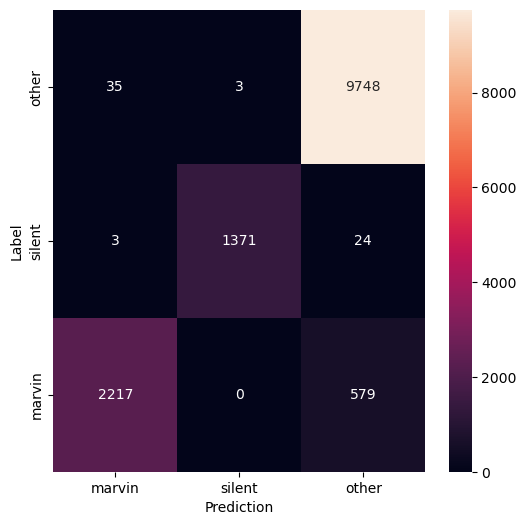

In [24]:
label_list = ['marvin', 'silent', 'other']
confusion_mtx = tf.math.confusion_matrix(labels, predictions)
plt.figure(figsize=(6, 6))
sns.heatmap(confusion_mtx, xticklabels=label_list, yticklabels=label_list, 
            annot=True, fmt='g')
plt.gca().invert_yaxis() # flip so origin is at bottom left
plt.xlabel('Prediction')
plt.ylabel('Label')
plt.show()

## Run Model on Long Waveform

The use case this benchmark is meant to model is one of detecting a "wakeword" (similar to "Hey Siri", "Alexa", or "OK Google") in a continuous stream of sound, including background noise.  So to mimic that use case, we will run the model on a longer waveform that includes several instances of the wakeword ("Marvin") and some background noise.

In [25]:
if streaming_config['musan_path'] is None or len(streaming_config['musan_path']) == 0:
  raise RuntimeError("Stopping before the long-wave test, which requires the musan dataset in streaming_config['musan_path']")

In [26]:
def trim_and_normalize(wav_in, rel_thresh):
  """
  Trims leading and trailing 'quiet' segments, where quiet is defined as 
  less than rel_thresh*max(wav_in).
  Then scales such that RMS of trimmed wav = 1.0
  """
  idx_start = np.min(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  idx_stop  = np.max(np.nonzero(ww_wav > np.max(ww_wav)*rel_thresh))
  
  wav_out = wav_in[idx_start:idx_stop]
  wav_out = wav_out / np.std(wav_out) 
  return wav_out

For the keras model, we can build an alternate version of the model that accepts inputs of arbitrary length.

In [27]:
pretrained_model_uses_qat = hasattr(model.layers[1], "quantizer")
Flags.variable_length=True
model_tv = models.get_model(args=Flags, use_qat=pretrained_model_uses_qat)
Flags.variable_length=False
# transfer weights from trained model into variable-length model
model_tv.set_weights(model.get_weights())

Input shape = [None, 1, 40]
Apple Silicon platform detected. Using legacy adam as standard Keras Adam is slow on this processor.


## Run Streaming Test on Long Waveform

A pre-constructed test wav is included in the repo (`long_wav.wav`) along with a json file that indicates the beginning and end of every instance of the wakeword, `long_wav_ww_windows.json`.

In [38]:
wav_sampling_freq, long_wav = wavfile.read("long_wav.wav")
assert wav_sampling_freq == samp_freq
t = np.arange(len(long_wav))/samp_freq
print(f"min/max of long wav = {np.min(long_wav)} / {np.max(long_wav)}")
long_wav = long_wav / 2**15 # scale into [-1.0, +1.0] range

ww_windows_file = 'sww_data_dir/sww_long_test.json' # start/stop points of wakewords in a list
with open(ww_windows_file, 'r') as fpi:
  ww_windows = json.load(fpi)

ww_windows = ww_windows[0]['detection_windows']

# construct waveform that shows when wakeword is present
ww_present = np.zeros(len(long_wav))
for t_start, t_stop in ww_windows:
  idx_start = int(t_start*samp_freq)
  idx_stop  = int(t_stop*samp_freq)
  ww_present[idx_start:idx_stop] = 1

min/max of long wav = -32768 / 27775


In [39]:
## build a feature extractor that can operate on longer waveforms.
## this one can operate on waveforms up to len(long_wav)
data_config_long = get_dataset.get_data_config(Flags, 'training')

with open("data_config_nb.json", "w") as fpo:
    json.dump(data_config_long, fpo, indent=4)
              
# long_wav = long_wav / np.max(np.abs(long_wav)) # scale into [-1.0, +1.0] range
t = np.arange(len(long_wav))/samp_freq

feature_extractor_long = get_dataset.get_lfbe_func(data_config_long)
# the feature extractor needs a label (in 1-hot format), but it doesn't matter what it is
# long_spec = feature_extractor_long({'audio':long_wav, 'label':[0.0, 0.0, 0.0]})['audio'].numpy()

# long_spec = feature_extractor_long(np.expand_dims(long_wav, 0)).numpy()
long_spec = feature_extractor_long(long_wav).numpy()

InvalidArgumentError: {{function_node __wrapped__Pad_device_/job:localhost/replica:0/task:0/device:GPU:0}} The first dimension of paddings must be the rank of inputs[2,2] [1,19200000,2] [Op:Pad] name: 

In [ ]:
# We'll count a detection when the softmax output for the wakeword exceeds the detection threshold det_thresh
det_thresh = 0.95

yy = model_tv(np.expand_dims(long_spec, 0))[0].numpy()
## shows detection when ww activation > thresh
ww_detected_spec_scale = (yy[:,0]>det_thresh).astype(int)
ww_true_detects, ww_false_detects, ww_false_rejects = util.get_true_and_false_detections(ww_detected_spec_scale, ww_present, Flags)

print(f"{np.sum(ww_false_detects!=0)} false detections.")
print(f"{np.sum(ww_true_detects!=0)} true detections.")
print(f"{np.sum(ww_false_rejects!=0)} false rejections.")

plt.plot(t, 1*util.zero2nan(ww_false_detects),   'rx', label='False Detections')
plt.plot(t, 2*(util.zero2nan(ww_true_detects)),  'g*', label='True Detections')
plt.plot(t, 3*(util.zero2nan(ww_false_rejects)), 'bo', label='False Rejections')
plt.legend()
plt.grid(True)

Take a look at some of the false positives here, and then in the next cell, some of the false negatives.

In [40]:
num_fp_clips_to_show = np.minimum(5, np.sum(ww_false_detects, dtype=np.int32))
for i in range(num_fp_clips_to_show):
  fp_start = np.nonzero(ww_false_detects)[0][i] # sample number where the false pos starts
  print(f"False positive at {fp_start/samp_freq:3.2f}s (sample {fp_start})")
  fp_clip = slice(fp_start-16000,fp_start+16000) # add 2s before and after
  display.display(display.Audio(long_wav[fp_clip], rate=16000))


NameError: name 'ww_false_detects' is not defined

In [ ]:
num_fn_clips_to_show = np.minimum(5, np.sum(ww_false_rejects, dtype=np.int32))
for i in range(num_fn_clips_to_show):
  fn_start = np.nonzero(ww_false_rejects)[0][i]
  print(f"False negative at {fn_start/samp_freq:3.2f}s (sample {fn_start})")
  fn_clip = slice(fn_start-16000,fn_start+16000)
  display.display(display.Audio(long_wav[fn_clip], rate=16000))


In [ ]:
def examine_clip(wav_clip, model, feature_extractor):
    # clip_spec = feature_extractor({'audio':wav_clip, 'label':[0.0, 0.0, 0.0]})['audio'].numpy()
    clip_spec = feature_extractor(wav_clip).numpy()
    spec_len = int(1.1*len(wav_clip)/(Flags.sample_rate*Flags.window_stride_ms/1000))
    clip_spec = clip_spec[:spec_len,:]
    yy_clip = model(np.expand_dims(clip_spec, 0))[0].numpy()

    plt.subplot(3,1,1)
    t_wav= np.arange(len(wav_clip))/Flags.sample_rate
    plt.plot(t_wav, wav_clip)
                     
    plt.subplot(3,1,2)
    # plt.imshow(clip_spec.squeeze().T, origin="lower", aspect="auto");
    t_spec= np.arange(clip_spec.shape[0])*(Flags.window_stride_ms/1000)
    mels = np.arange(clip_spec.shape[-1])
    plt.pcolormesh(t_spec, mels, clip_spec.squeeze().T)
  
    plt.subplot(3,1,3)
    t_yy= np.arange(yy_clip.shape[0])*(Flags.window_stride_ms/1000)
    print(f"t_yy shape = {t_yy.shape}, yy_clip shape = {yy_clip.shape}")
    
    plt.plot(t_yy, yy_clip, [0,t_yy[-1]], [det_thresh, det_thresh]);
    plt.legend(label_list+[f"Threshold ({det_thresh})"], loc='lower left', fontsize=8);
   
    display.display(display.Audio(wav_clip, rate=16000))
    plt.tight_layout()



Now we can take a closer look at one of the errors, showing the waveform plot, listening to the audio, and showing the spectrogram, along with the model outputs.  

In [ ]:
error_idx = 0  # which false pos/neg to look at
# you can replace ww_false_detects with ww_false_rejects to view false negatives
clip_idx = np.nonzero(ww_false_rejects)[0][error_idx] 
clip_range = slice(clip_idx-2*Flags.sample_rate,clip_idx+2*Flags.sample_rate)
print(f"Examining clip from {clip_range.start} to {clip_range.stop}")
wav_clip = long_wav[clip_range]
examine_clip(wav_clip, model_tv, feature_extractor_long)


## Quantized Model on Long Wave

In [ ]:
yy_q = np.nan*np.zeros((long_spec.shape[0]-model.input.shape[1]+1,3))
t0 = time.time(); 
preds_q = []
labels = []

for idx in range(long_spec.shape[0]-model.input.shape[1]+1):
  spec = long_spec[idx:idx+input_shape[1],:,:]
  spec = np.expand_dims(spec, 0) # add batch dimension  
  spec_q = np.array(spec/input_scale + input_zero_point, dtype=np.int8)
  
  interpreter.set_tensor(input_details[0]['index'], spec_q)
  interpreter.invoke()
  # The function `get_tensor()` returns a copy of the tensor data.
  # Use `tensor()` in order to get a pointer to the tensor.
  yy_q[idx,:] = interpreter.get_tensor(output_details[0]['index'])

# Dequantize so that softmax output is in range [0,1]
yy_q = (yy_q.astype(np.float32) - output_zero_point)*output_scale

t1 = time.time(); 
print(f"Ran quantized model on long wave in {t1-t0:1.2f} s")

In [ ]:
det_thresh = 0.95
## shows detection when wakeword activation is strongest output
# ww_detected_spec_scale = (np.argmax(yy, axis=1)==0) # detections on the time scale of spectrograms

## shows detection when ww activation > thresh
ww_detected_spec_scale = (yy_q[:,0]>det_thresh).astype(int)

ww_true_detects, ww_false_detects, ww_false_rejects = util.get_true_and_false_detections(ww_detected_spec_scale, ww_present, Flags)

print(f"{np.sum(ww_false_detects!=0)} false detections.")
print(f"{np.sum(ww_true_detects!=0)} true detections.")
print(f"{np.sum(ww_false_rejects!=0)} false rejections.")

In [ ]:
plt.plot(t, 1*util.zero2nan(ww_false_detects),   'rx', label='False Detections')
plt.plot(t, 2*(util.zero2nan(ww_true_detects)),  'g*', label='True Detections')
plt.plot(t, 3*(util.zero2nan(ww_false_rejects)), 'bs', label='False Rejections')
plt.legend()
plt.grid(True)

## Scratch Space
